1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.
2. Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

In [51]:
x, y, coef_w = make_regression(
    n_samples=1000,
    n_features=2,
    n_targets=1,
    bias=0.0,
    effective_rank=None,
    tail_strength=0.5,
    noise=5,
    shuffle=True,
    coef=True,
    random_state=33)

In [52]:
coef_w

array([36.31774515, 56.81396191])

In [53]:
x

array([[ 0.74473695, -0.76399399],
       [ 2.77553547,  0.31273507],
       [ 0.51612457, -1.28077842],
       ...,
       [-2.21084522,  1.58418413],
       [ 1.34504259, -0.55339663],
       [-0.44064812, -1.36952065]])

In [54]:
len(x)

1000

In [55]:
x.shape[0]

1000

In [56]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(y, y_pred):
    return np.mean((y - y_pred)**2)

В первом ДЗ мы все выполнили для разовой задачи. Такой подход больше не приемлем, нужно писать универсальные функции для каждого метода

Какие функции нужно написать: 
    - метрика качества (определение ошибки) 
    - функция обучения линейной модели
    - функция, которая визуализирует графики ошибок (MSE) и скорости обучения (alpha) для двух методов 

In [57]:
# Проведем масштабирование данных: 
# Получим средние значения и стандартное отклонение по столбцам
means = np.mean(x, axis=0)
stds = np.std(x, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву

# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        x[i][j] = (x[i][j] - means[j])/stds[j]

In [58]:
x

array([[ 0.72357397, -0.76697377],
       [ 2.75640434,  0.34660446],
       [ 0.49473286, -1.30144424],
       ...,
       [-2.23496531,  1.66156664],
       [ 1.32448022, -0.54916908],
       [-0.4629971 , -1.39322352]])

In [59]:
def eval_sgd_model(x, y, qty_in_batch = 1, alpha = 0.005, n_iters = 1000, tolerance = 1e-4):
    
    #рандомно зададим веса с нормальным распределением
    weights = np.random.randn(x.shape[1])
    
    all_errors = []
    all_weights = []
    
    n_batches = len(y) // qty_in_batch
    
    #если нацело не делится, то добавляем еще один: 
    if len(y) % qty_in_batch:
        n_batches += 1
        
    for i in range(n_iters):
        for batch_number in range(n_batches):
            start_ = qty_in_batch*batch_number
            end_ = qty_in_batch*(batch_number+1)
                
            # print(batch_number, qty_in_batch, start_, end_)
                
            x_tmp = x[start_ : end_]
            y_tmp = y[start_ : end_]
            y_pred_tmp = np.dot(weights, x_tmp.T)
            err = mserror(y_tmp, y_pred_tmp)
            weights -= 2*alpha*np.dot(x_tmp.T,(y_pred_tmp - y_tmp))/len(y_pred_tmp)
            all_errors.append(err)
            all_weights.append(weights)

        if i > 2 and np.abs(err - all_errors[-2]) < tolerance:
            break
        
    return weights, all_weights, all_errors

In [60]:
np.random.seed(27)
gd_weights, gd_all_weights, gd_all_errors = eval_sgd_model(x, y, qty_in_batch=x.shape[0])
#для обычного GD: qty_in_batch=x.shape[0]

In [61]:
np.random.seed(27)
sgd_weights, sgd_all_weights, sgd_all_errors = eval_sgd_model(x, y, qty_in_batch=1)

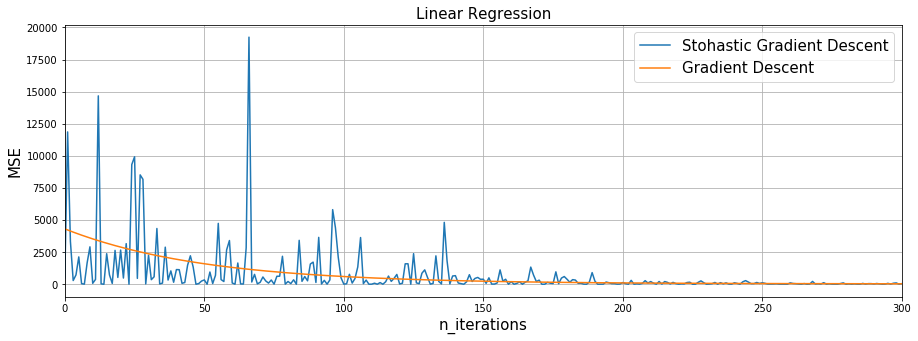

In [62]:
fig = plt.figure(figsize=(15, 5))
plt.title("Linear Regression", size=15)
plt.plot(sgd_all_errors, label="Stohastic Gradient Descent")
plt.plot(gd_all_errors, label="Gradient Descent")
plt.legend(loc="best", fontsize=15)
plt.xlabel("n_iterations", size=15)
plt.ylabel("MSE", size=15)
plt.xlim(0, 300)
plt.grid()

2. Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

In [63]:
def eval_sgd_ridge_model(x, y, qty_in_batch = 1, alpha = 0.005, cf:float = 0.01, n_iters = 1000, tolerance = 1e-4):
    
    #рандомно зададим веса с нормальным распределением
    weights = np.random.randn(x.shape[1])
    
    all_errors = []
    all_weights = []
    
    n_batches = len(y) // qty_in_batch
    
    #если нацело не делится, то добавляем еще один: 
    if len(y) % qty_in_batch:
        n_batches += 1
        
    for i in range(n_iters):
        for batch_number in range(n_batches):
            start_ = qty_in_batch*batch_number
            end_ = qty_in_batch*(batch_number+1)
                
            # print(batch_number, qty_in_batch, start_, end_)
                
            x_tmp = x[start_ : end_]
            y_tmp = y[start_ : end_]
            y_pred_tmp = np.dot(weights, x_tmp.T)
            err = mserror(y_tmp, y_pred_tmp)
            weights -= 2*alpha*(np.sum(x_tmp.T*(y_pred_tmp - y_tmp), axis=1)/len(y_pred_tmp) + 2*cf * weights)
            all_errors.append(err)
            all_weights.append(weights)

        if i > 2 and np.abs(err - all_errors[-2]) < tolerance:
            break
        
    return weights, all_weights, all_errors

In [64]:
sgd_ridge_weights, sgd_ridge_all_weights, sgd_ridge_all_errors = eval_sgd_ridge_model(x, y, qty_in_batch=1)

In [65]:
gd_ridge_weights, gd_ridge_all_weights, gd_ridge_all_errors = eval_sgd_ridge_model(x, y, qty_in_batch=x.shape[0])

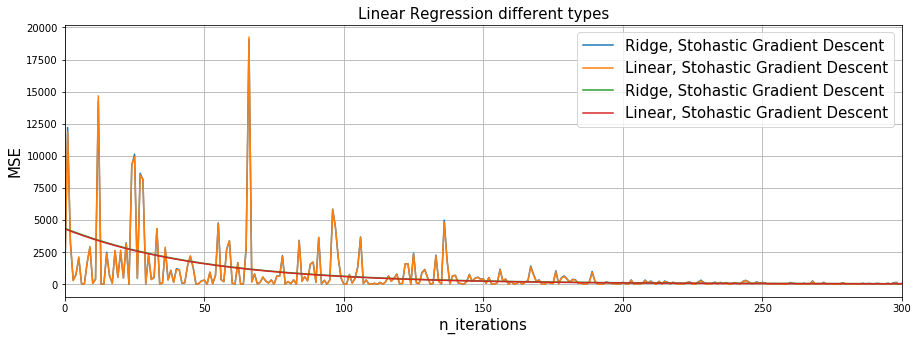

In [66]:
fig = plt.figure(figsize=(15, 5))
plt.title("Linear Regression different types", size=15)
plt.plot(sgd_ridge_all_errors, label="Ridge, Stohastic Gradient Descent")
plt.plot(sgd_all_errors, label="Linear, Stohastic Gradient Descent")
plt.plot(gd_ridge_all_errors, label="Ridge, Stohastic Gradient Descent")
plt.plot(gd_all_errors, label="Linear, Stohastic Gradient Descent")
plt.legend(loc="best", fontsize=15)
plt.xlabel("n_iterations", size=15)
plt.ylabel("MSE", size=15)
plt.xlim(0, 300)
plt.grid()